In [103]:
import sys
print(sys.version)

3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]


In [104]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [38]:
# import pandas as pd

# # Load the dataset
# weather_data = pd.read_csv('weather.csv')

# # Map for converting numeric months to short month names
# month_map = {
#     "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
#     "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
#     "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"
# }

# # Function to format the 'Price Date' column
# def format_price_date(date_str):
#     """
#     Convert the 'Price Date' from 'dd-mm-yyyy' to 'dd-MMM-yy'.
#     """
#     try:
#         # Split the date into day, month, and year
#         day, month, year = date_str.split('-')
#         # Convert the month to its string representation
#         month_str = month_map[month]
#         # Keep the last two digits of the year
#         year_short = year[-2:]
#         # Recombine into the desired format
#         return f"{day}-{month_str}-{year_short}"
#     except Exception as e:
#         print(f"Error formatting date: {date_str}. Skipping...")
#         return date_str  # Return as-is if there's an error

# # Apply the formatting function to the 'Price Date' column
# weather_data['Price Date'] = weather_data['Price Date'].apply(format_price_date)

# # Save the cleaned dataset
# weather_data.to_csv('formatted_weather.csv', index=False)
# print("Date formatting completed. Cleaned file saved as 'formatted_weather.csv'.")

In [ ]:
def load_and_preprocess_data():
    """
    Load and preprocess the weather and crop price datasets.
    """
    import pandas as pd
    
    # Load datasets
    weather_data = pd.read_csv('formatted_weather.csv')
    crop_prices = {
        'brinjal': pd.read_csv('brinjalprice.csv'),
        'potato': pd.read_csv('potatoprice.csv'),
        'apple': pd.read_csv('apple.csv'),
        'onion': pd.read_csv('onionprice.csv'),
        'tomato': pd.read_csv('tomatoprice.csv'),
        'coconut': pd.read_csv('coconut.csv'),
        'cotton': pd.read_csv('cotton.csv'),
        'groundnut': pd.read_csv('groundnut.csv'),
        'maize': pd.read_csv('maize.csv'),
        'paddy': pd.read_csv('paddy.csv'),
        'redchilli': pd.read_csv('redchilli.csv'),
        'turmeric': pd.read_csv('turmeric.csv'),
        'sunflower': pd.read_csv('sunflower.csv'),
        'lemon': pd.read_csv('lemon.csv'),
        'orange': pd.read_csv('orange.csv'),
        'banagreen': pd.read_csv('bananagreen.csv'),
        'beans': pd.read_csv('beans.csv'),
        'beetroot': pd.read_csv('beetroot.csv'),
        'bittergourd': pd.read_csv('bittergourd.csv'),
        'cabbage': pd.read_csv('cabbage.csv')
    }
    
    # Example for weather data
    weather_data['Price Date'] = pd.to_datetime(weather_data['Price Date'], format='%d-%b-%y', dayfirst=True)

    for crop_name, crop_df in crop_prices.items():
        crop_prices[crop_name]['Price Date'] = pd.to_datetime(crop_df['Price Date'], format='%d-%b-%y', dayfirst=True)

    # Handle missing values
    # Fill missing weather data with the column mean
    weather_data.fillna(weather_data.mean(), inplace=True)
    
    # Fill missing price
    for crop_name, crop_df in crop_prices.items():
        crop_prices[crop_name] = crop_df.copy()
        crop_prices[crop_name]['Modal Price (Rs./Quintal)'] = (
            crop_prices[crop_name]['Modal Price (Rs./Quintal)'].ffill().bfill()
        )
  
    return weather_data, crop_prices


In [40]:
def merge_weather_price_data(weather_data, crop_prices):
    """
    Merge weather data with price data with improved matching and validation
    """
    if weather_data is None or crop_prices is None:
        return None, None

    merged_data = {}
    weather_features = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']
    
    # Verify weather features
    missing_features = [f for f in weather_features if f not in weather_data.columns]
    if missing_features:
        print(f"Missing weather features: {missing_features}")
        return None, None

    for crop_name, price_data in crop_prices.items():
        try:
            print(f"\nMerging data for {crop_name}")
            #price data
            price_data = price_data[['Price Date', 'Modal Price (Rs./Quintal)']].copy()
            
            # date sorted
            price_data = price_data.sort_values('Price Date')
            weather_data = weather_data.sort_values('Price Date')
            
            # Merge with weather data
            merged = pd.merge(price_data, weather_data[['Price Date'] + weather_features], 
                            on='Price Date', how='inner')
            
            print(f"Records after merging: {len(merged)}")
            
            if len(merged) >= 30:
                merged_data[crop_name] = merged
            else:
                print(f"Warning: Insufficient data after merging ({len(merged)} < 30)")
            
        except Exception as e:
            print(f"Error merging data for {crop_name}: {e}")
            continue

    if not merged_data:
        print("No crops had sufficient data after merging")
        return None, None

    return merged_data, weather_features

In [41]:
def prepare_sequences(data, features, target_column, n_timesteps):
    """
    Prepare sequences for LSTM model
    """
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # Scale features and target
    X_scaled = scaler_X.fit_transform(data[features])
    y_scaled = scaler_y.fit_transform(data[[target_column]])

    X, y = [], []
    for i in range(n_timesteps, len(data)):
        X.append(X_scaled[i-n_timesteps:i])
        y.append(y_scaled[i])

    return np.array(X), np.array(y), scaler_X, scaler_y

In [42]:
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [43]:
def train_model(X_train, y_train, X_val, y_val, input_shape, crop_name):
    """
    Train LSTM model with early stopping
    """
    model = build_lstm_model(input_shape)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    return model, history

In [44]:
def predict_future(model, last_sequence, n_steps, scaler_y):
    """
    Generate future predictions
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0, 0])
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_pred[0]

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler_y.inverse_transform(future_predictions)


In [45]:
def plot_predictions(y_true, y_pred, future_pred, crop_name):
    """
    Plot actual values, predictions, and future predictions
    """
    plt.figure(figsize=(15, 8))

    # Ensure arrays are 1-dimensional
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    future_pred = future_pred.ravel()

    # Create time indices
    time_index = np.arange(len(y_true))
    future_index = np.arange(len(y_true), len(y_true) + len(future_pred))

    # Plot actual and predicted values
    plt.plot(time_index, y_true, label='Actual', color='blue', linewidth=2)
    plt.plot(time_index, y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)

    # Plot future predictions
    plt.plot(future_index, future_pred, label='Future Predictions',
             color='green', linestyle=':', linewidth=2)

    # Add prediction uncertainty
    std_dev = np.std(np.abs(y_true - y_pred))
    plt.fill_between(future_index,
                    future_pred - std_dev,
                    future_pred + std_dev,
                    color='green', alpha=0.2)

    plt.title(f'{crop_name.capitalize()} Price Prediction', fontsize=16, pad=20)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Price (Rs./Quintal)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

In [46]:
def evaluate_model(y_true, y_pred, crop_name):
    """
    Calculate and print evaluation metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\nMetrics for {crop_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae}


Merging data for brinjal
Records after merging: 1606

Merging data for potato
Records after merging: 1499

Merging data for apple
Records after merging: 466

Merging data for onion
Records after merging: 1612

Merging data for tomato
Records after merging: 1612

Merging data for coconut
Records after merging: 6725

Merging data for cotton
Records after merging: 28

Merging data for groundnut
Records after merging: 1228

Merging data for maize
Records after merging: 1591

Merging data for paddy
Records after merging: 310

Merging data for redchilli
Records after merging: 1

Merging data for turmeric
Records after merging: 1991

Merging data for sunflower
Records after merging: 4

Merging data for lemon
Records after merging: 1462

Merging data for orange
Records after merging: 372

Merging data for banagreen
Records after merging: 1546

Merging data for beans
Records after merging: 1475

Merging data for beetroot
Records after merging: 1479

Merging data for bittergourd
Records after m

c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 0.1839 - val_loss: 0.0280
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0462 - val_loss: 0.0197
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0435 - val_loss: 0.0213
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0442 - val_loss: 0.0155
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0404 - val_loss: 0.0160
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0364 - val_loss: 0.0205
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0342 - val_loss: 0.0253
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0386 - val_loss: 0.0189
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0331 - val_loss: 0.0184
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0304 - val_loss: 0.0189
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0282 - val_loss: 0.0186
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.

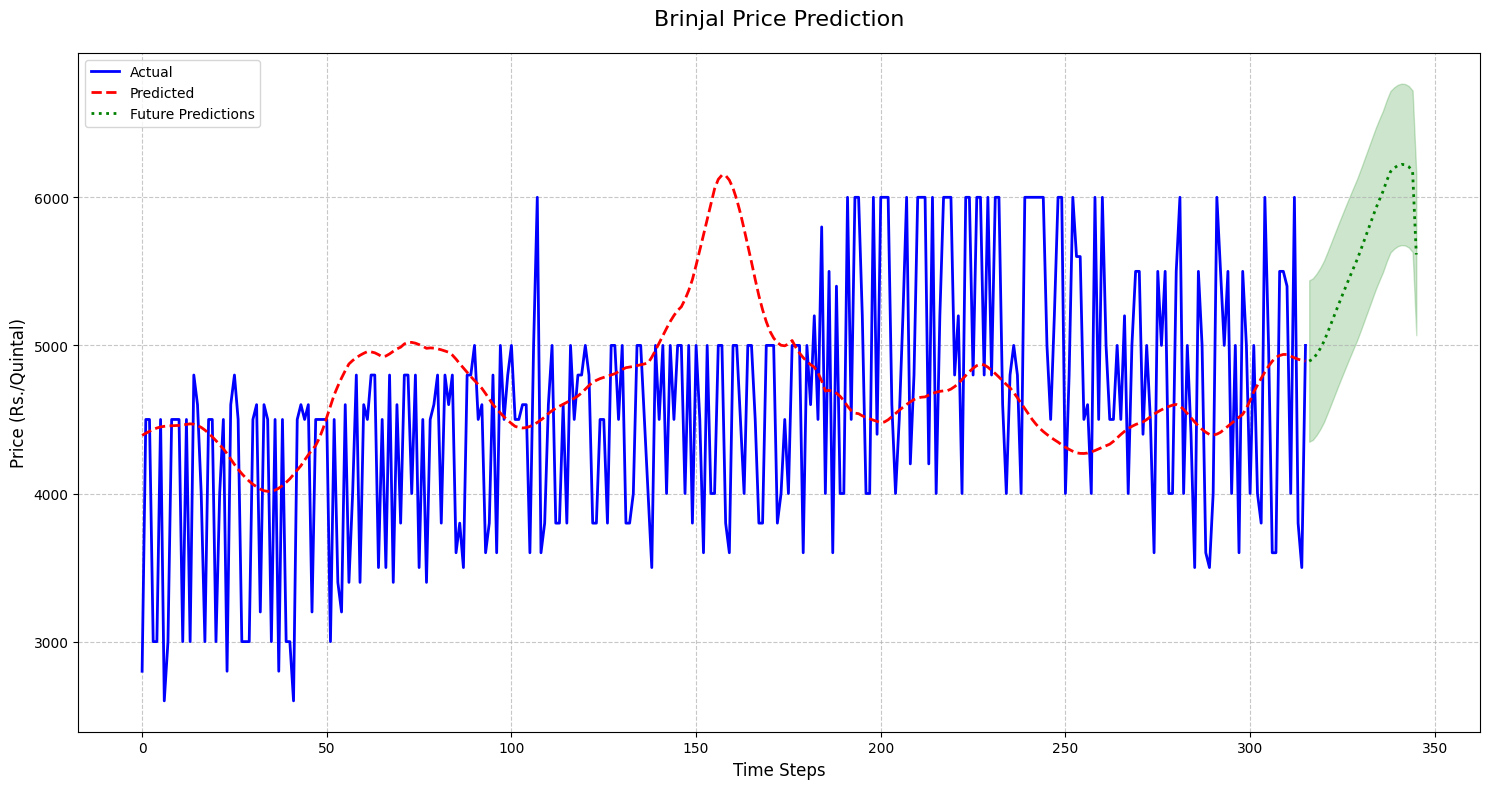


Processing potato...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.2167 - val_loss: 0.0104
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0376 - val_loss: 0.0120
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0336 - val_loss: 0.0077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0293 - val_loss: 0.0090
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0326 - val_loss: 0.0070
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0302 - val_loss: 0.0085
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0269 - val_loss: 0.0093
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0267 - val_loss: 0.0192
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0275 - val_loss: 0.0176
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0275 - val_loss: 0.0173
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0304 - val_loss: 0.0146
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0231 - val_l

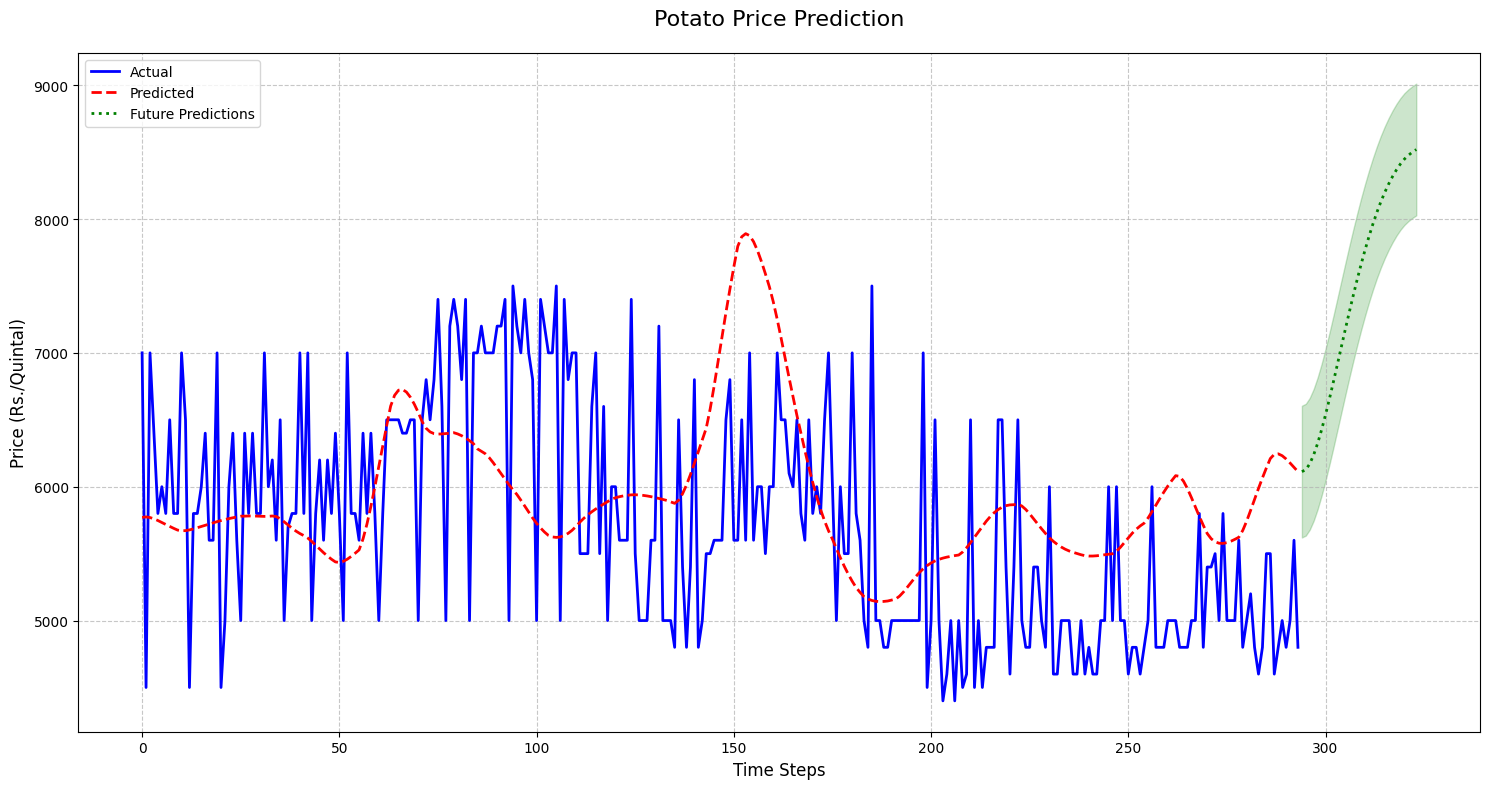


Processing apple...


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.3187 - val_loss: 0.0175
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.1000 - val_loss: 0.0608
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0898 - val_loss: 0.0304
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0789 - val_loss: 0.0617
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0629 - val_loss: 0.0798
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0710 - val_loss: 0.0513
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0627 - val_loss: 0.0669
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0607 - val_loss: 0.0634
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0492 - val_loss: 0.0819
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0525 - val_loss: 0.0541
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0370 - val_loss: 0.0576
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step

Metrics for apple:
MSE

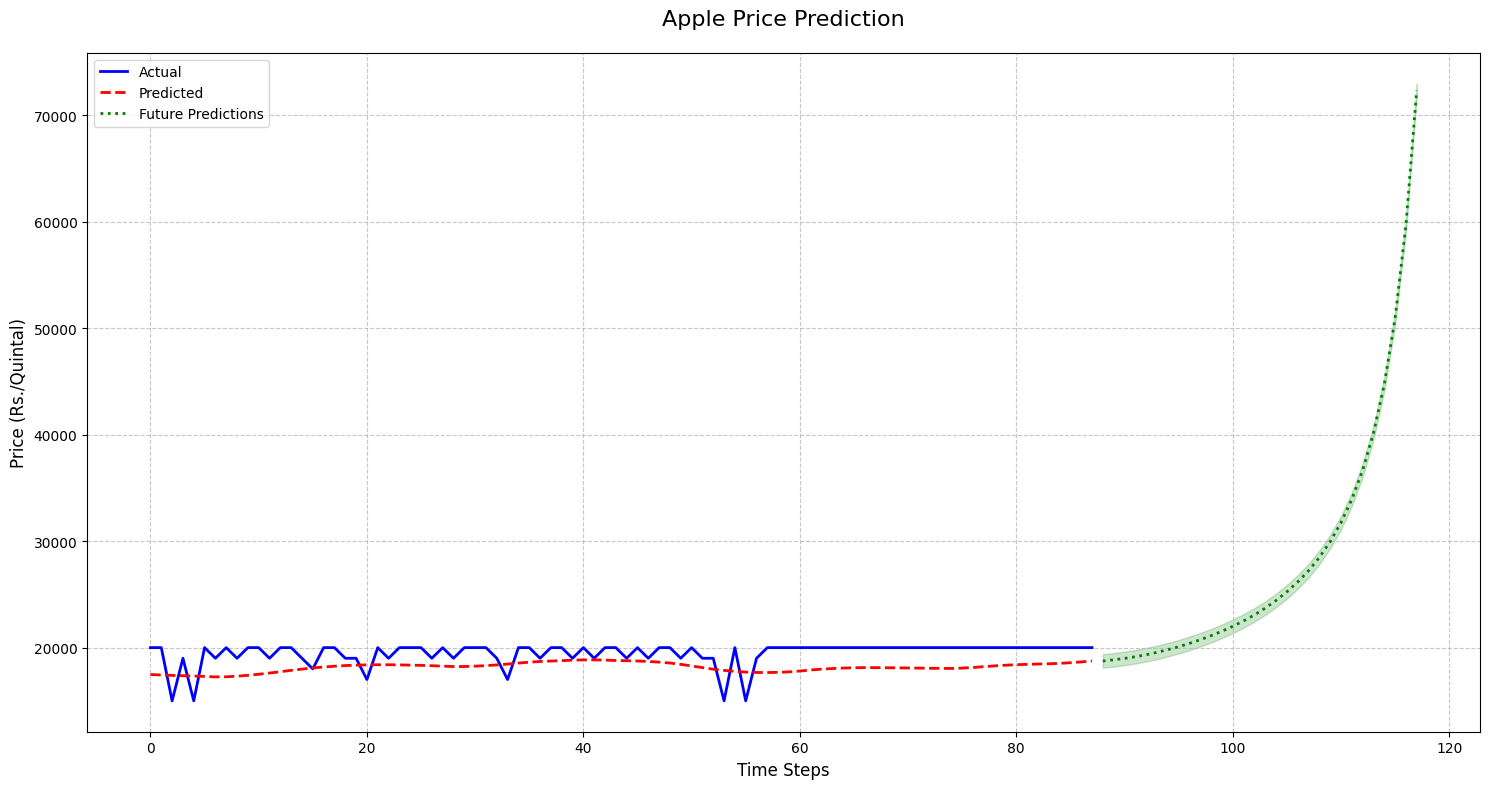


Processing onion...


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.1558 - val_loss: 0.0482
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0239 - val_loss: 0.0485
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0225 - val_loss: 0.0464
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0182 - val_loss: 0.0466
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0161 - val_loss: 0.0437
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0181 - val_loss: 0.0426
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0176 - val_loss: 0.0430
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0146 - val_loss: 0.0429
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0146 - val_loss: 0.0403
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0128 - val_loss: 0.0405
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0124 - val_loss: 0.0380
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

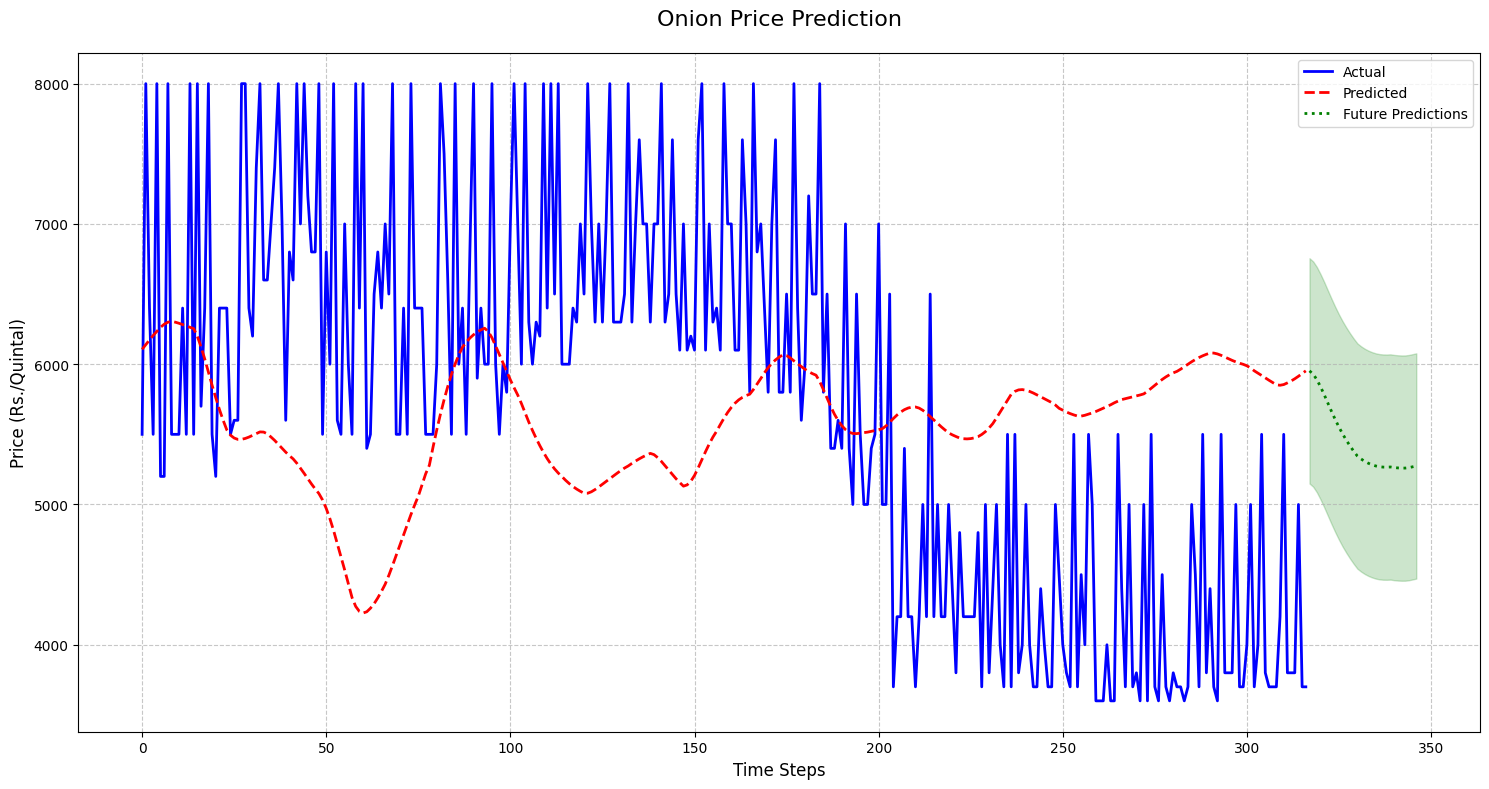


Processing tomato...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0996 - val_loss: 0.0373
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0421 - val_loss: 0.0465
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0358 - val_loss: 0.0541
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0303 - val_loss: 0.0530
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0304 - val_loss: 0.0634
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0286 - val_loss: 0.0691
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0266 - val_loss: 0.0771
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0225 - val_loss: 0.0592
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0220 - val_loss: 0.0550
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0228 - val_loss: 0.0524
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0216 - val_loss: 0.0479
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

Metrics for tomato:
MSE: 1917330.

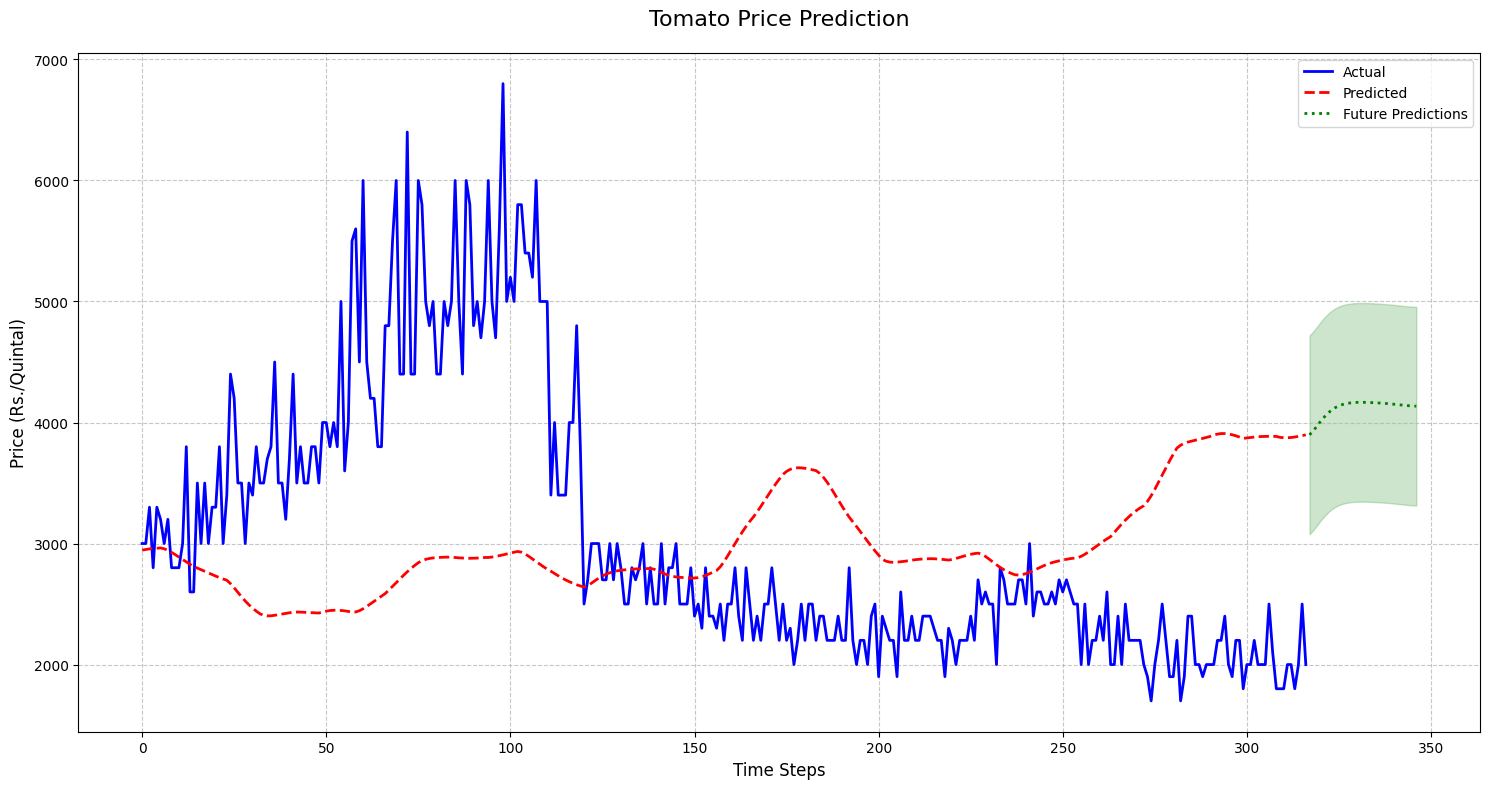


Processing coconut...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 5.9311e-04 - val_loss: 0.0059
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 2.3254e-04 - val_loss: 0.0059
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2.4116e-04 - val_loss: 0.0056
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.2568e-04 - val_loss: 0.0049
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.3344e-04 - val_loss: 0.0055
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.1189e-04 - val_loss: 0.0049
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.3822e-04 - val_loss: 0.0053
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.0565e-04 - val_loss: 0.0050
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.2276e-04 - val_loss: 0.0053
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2.0997e-04 - val_loss: 0.0051
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 2.1656e-04 - val_loss: 0.0052
Epoch 1

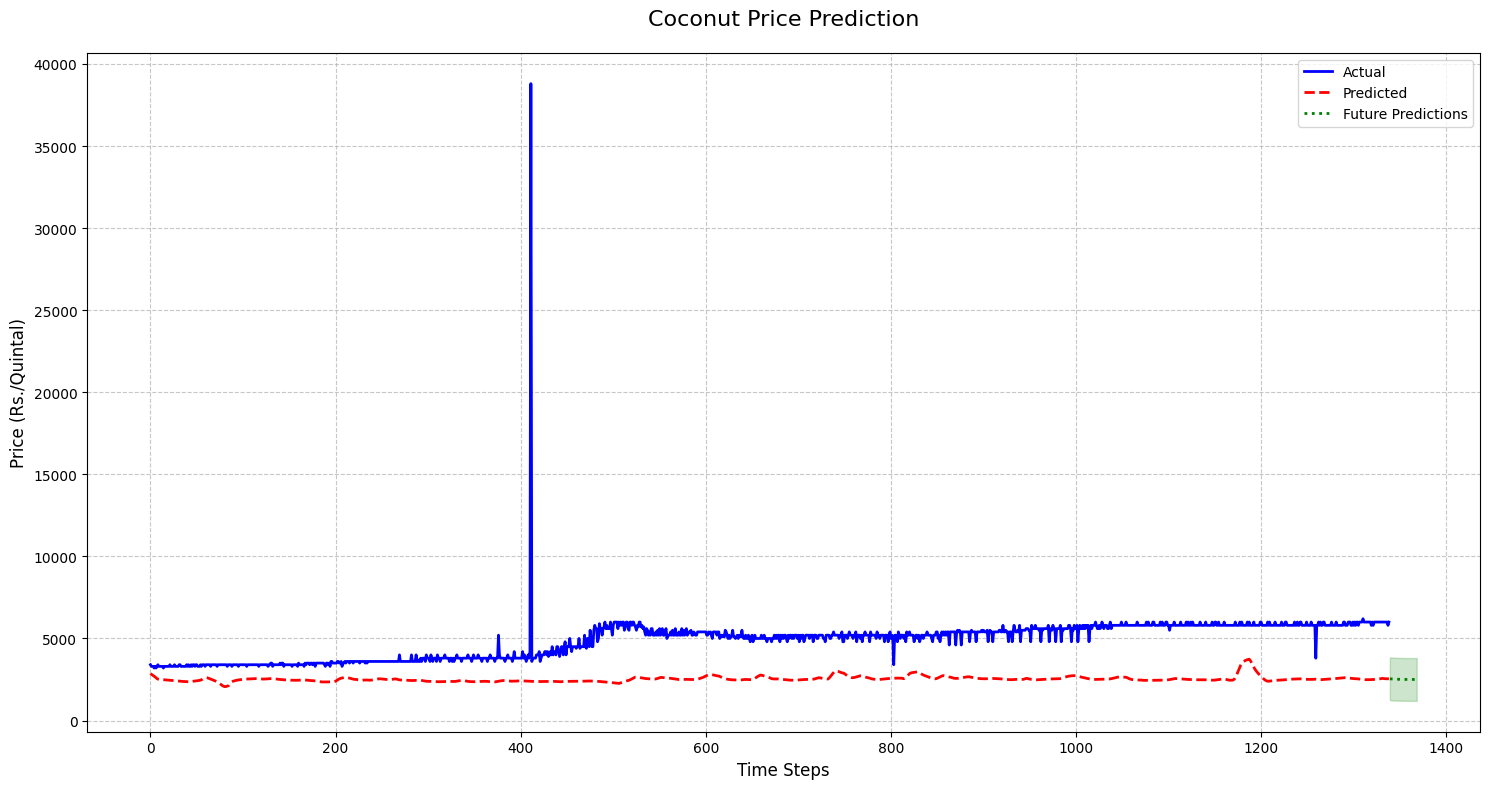


Processing groundnut...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.1802 - val_loss: 0.0373
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0619 - val_loss: 0.0453
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0558 - val_loss: 0.0921
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0532 - val_loss: 0.0568
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0501 - val_loss: 0.0725
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0509 - val_loss: 0.0718
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0478 - val_loss: 0.0997
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0470 - val_loss: 0.0741
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0473 - val_loss: 0.1314
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0368 - val_loss: 0.0718
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0459 - val_loss: 0.1447
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Metrics for groundnut:
MSE: 510617.

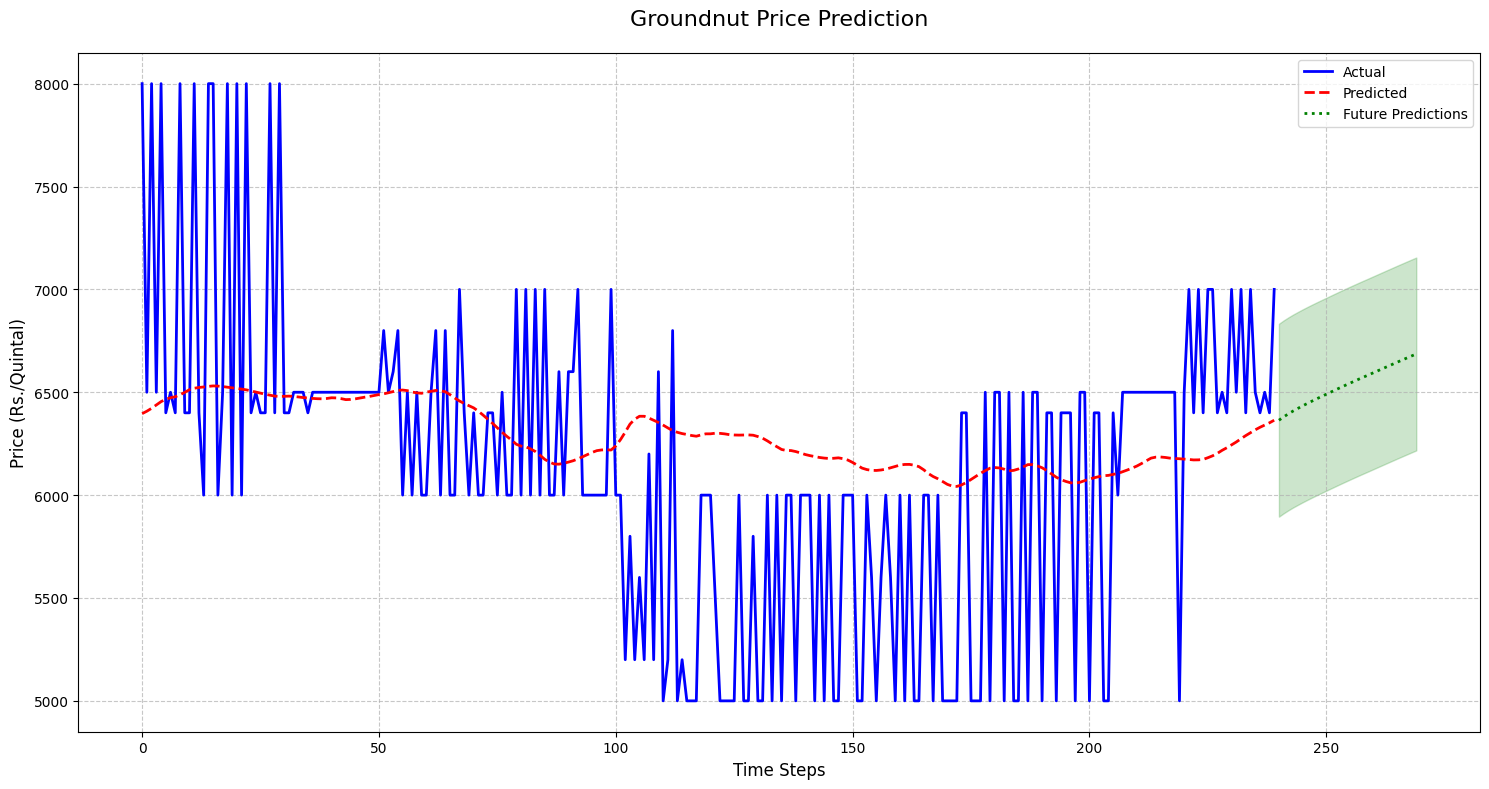


Processing maize...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0831 - val_loss: 0.0685
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0344 - val_loss: 0.0983
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0320 - val_loss: 0.1071
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0319 - val_loss: 0.1104
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0304 - val_loss: 0.0884
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0265 - val_loss: 0.0759
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0267 - val_loss: 0.0969
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0262 - val_loss: 0.0950
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0263 - val_loss: 0.0818
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0215 - val_loss: 0.0961
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0204 - val_loss: 0.1106
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

Metrics for maize:
MSE: 555985.75

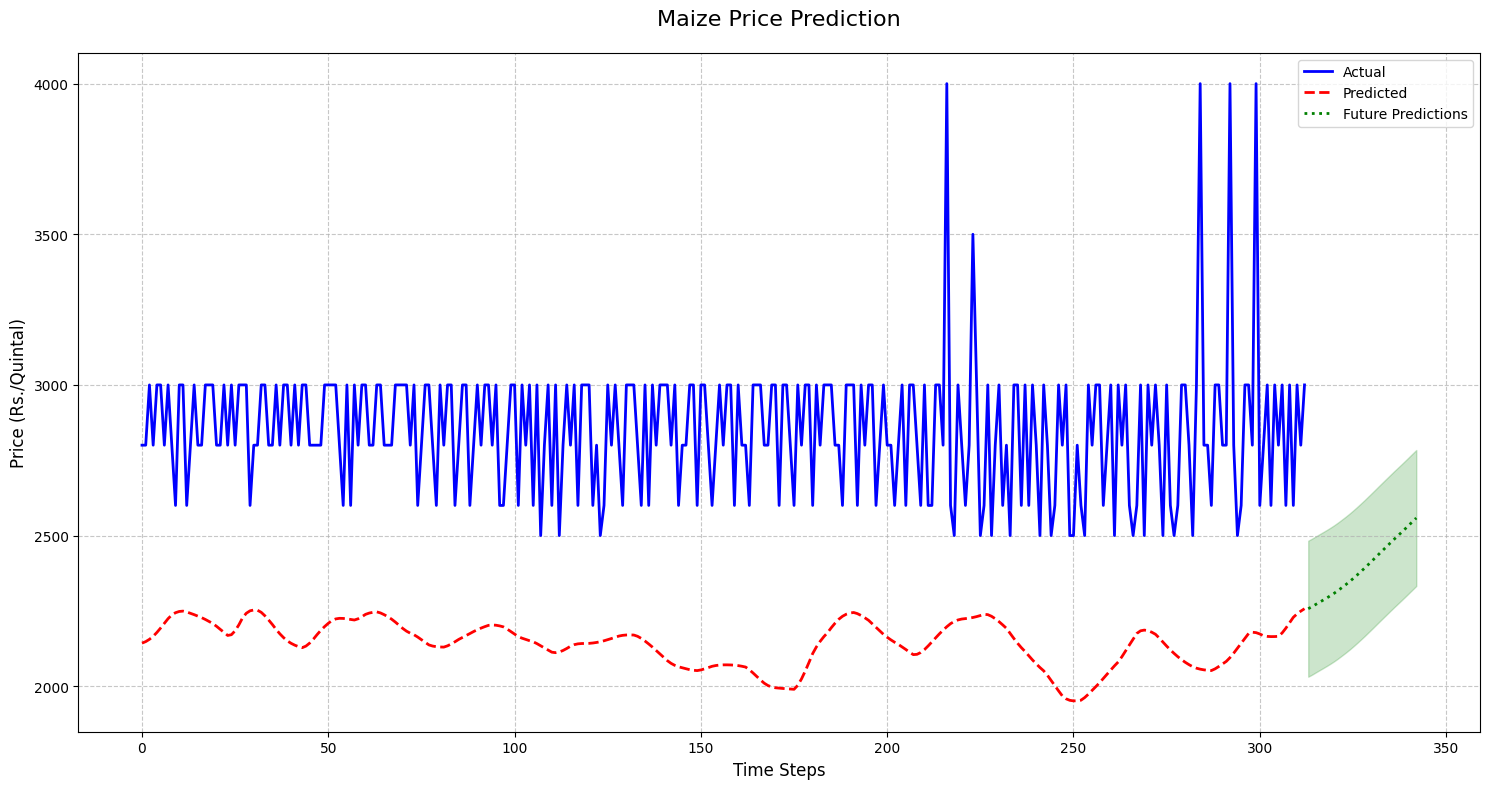


Processing paddy...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0729 - val_loss: 0.0971
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0154 - val_loss: 0.0263
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0123 - val_loss: 0.0433
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0085 - val_loss: 0.0535
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0094 - val_loss: 0.0424
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0067 - val_loss: 0.0359
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0076 - val_loss: 0.0424
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0485
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0085 - val_loss: 0.0408
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0068 - val_loss: 0.0397
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0060 - val_loss: 0.0446
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0075 - val_loss: 0.0406
2/2 ━━━━━━━━

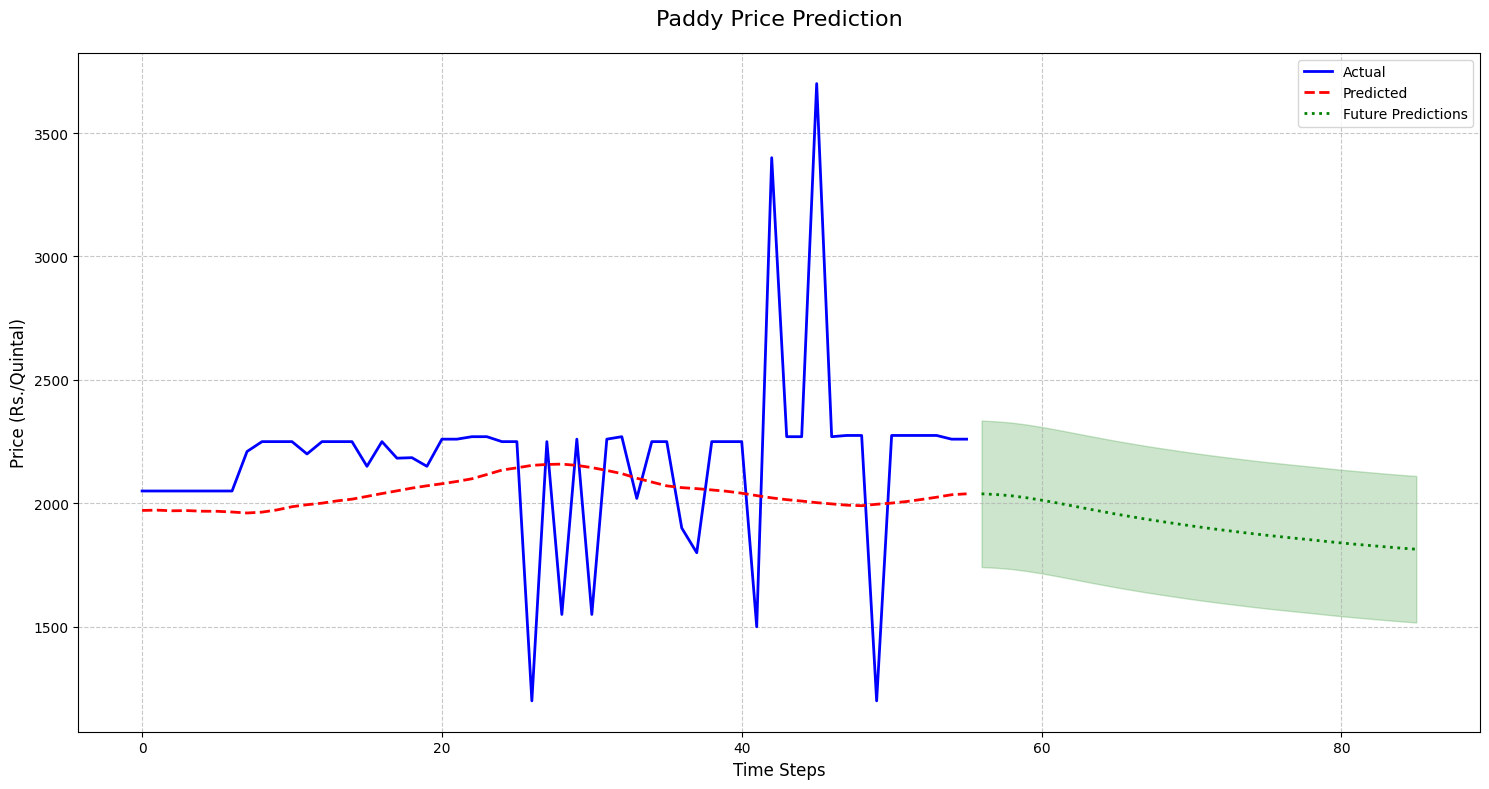


Processing turmeric...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0372 - val_loss: 0.0784
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0079 - val_loss: 0.0731
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0074 - val_loss: 0.0840
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - val_loss: 0.0858
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0067 - val_loss: 0.1011
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0069 - val_loss: 0.0821
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0066 - val_loss: 0.0909
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - val_loss: 0.0861
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061 - val_loss: 0.0757
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0059 - val_loss: 0.0826
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0058 - val_loss: 0.0793
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0050 - val_l

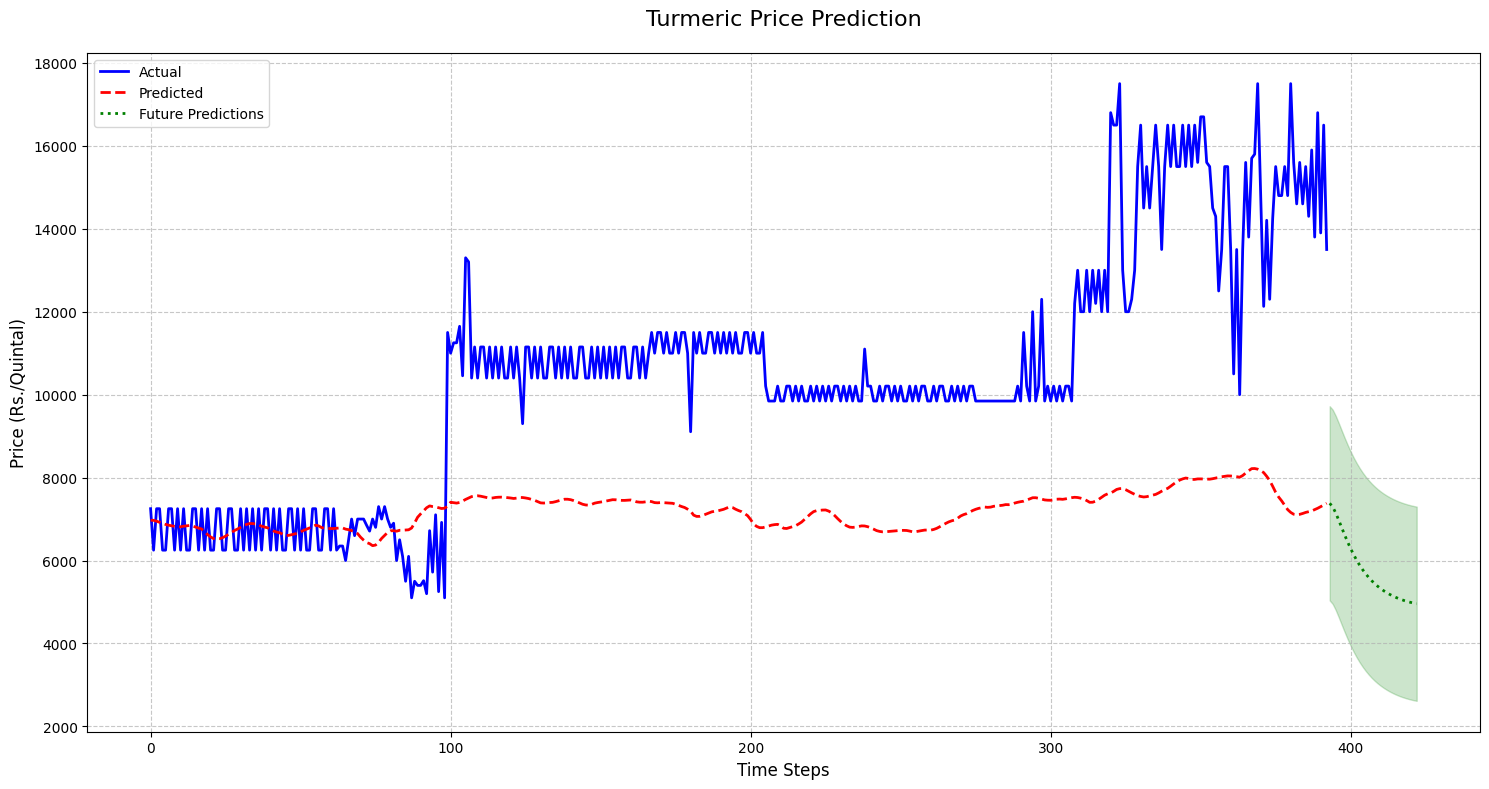


Processing lemon...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0312 - val_loss: 0.0075
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0057 - val_loss: 0.0079
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0053 - val_loss: 0.0071
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0048 - val_loss: 0.0086
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040 - val_loss: 0.0101
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0043 - val_loss: 0.0084
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 0.0139
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0037 - val_loss: 0.0146
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0032 - val_l

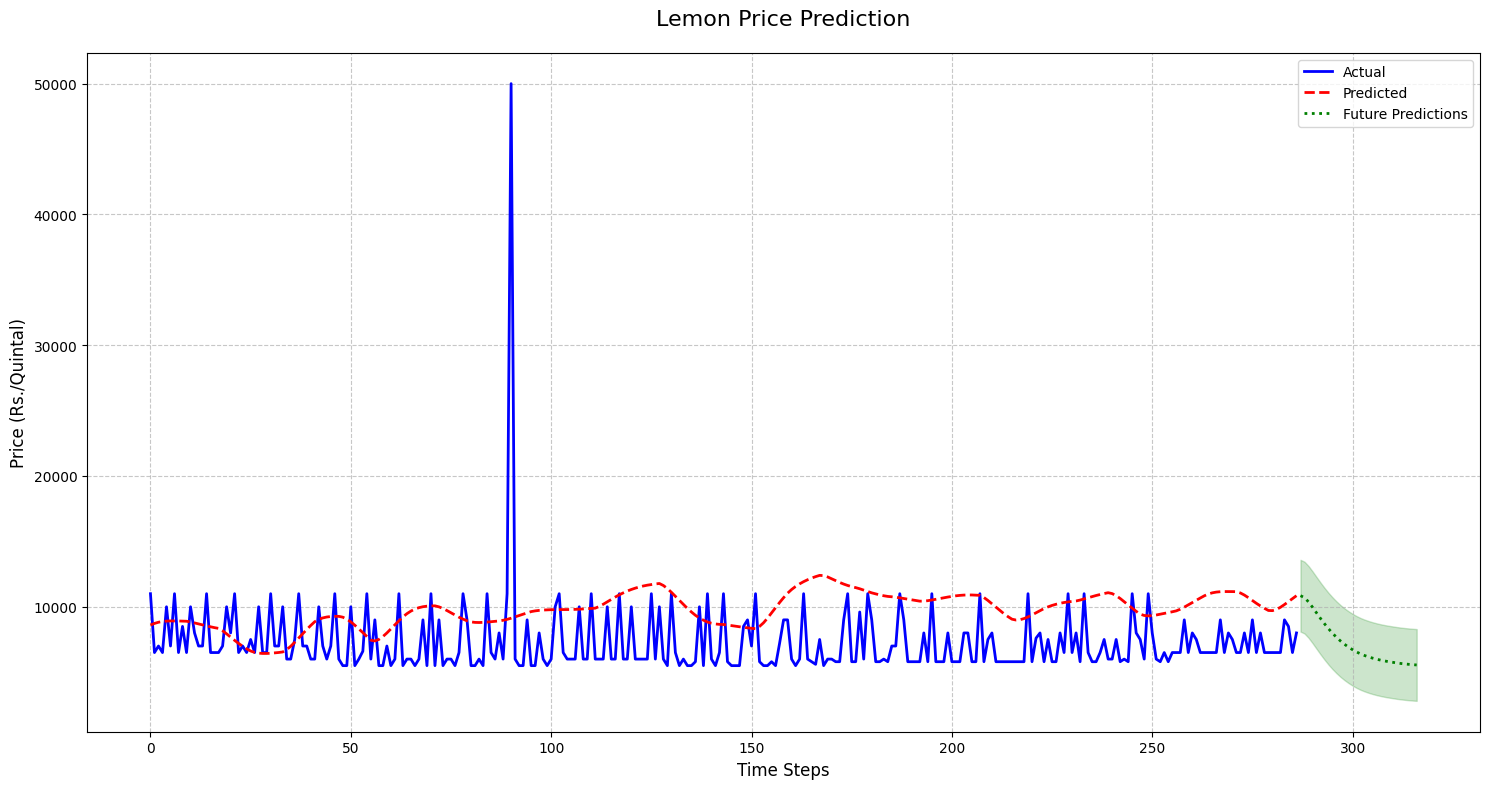


Processing orange...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.4279 - val_loss: 0.0170
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2037 - val_loss: 0.0793
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1483 - val_loss: 0.0346
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0883 - val_loss: 0.0116
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0547 - val_loss: 0.0100
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0444 - val_loss: 0.0121
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0477 - val_loss: 0.0113
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0387 - val_loss: 0.0167
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0398 - val_loss: 0.0136
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0411 - val_loss: 0.0146
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0270 - val_loss: 0.0177
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0281 - val_loss: 0.0164
Epoch 13/50


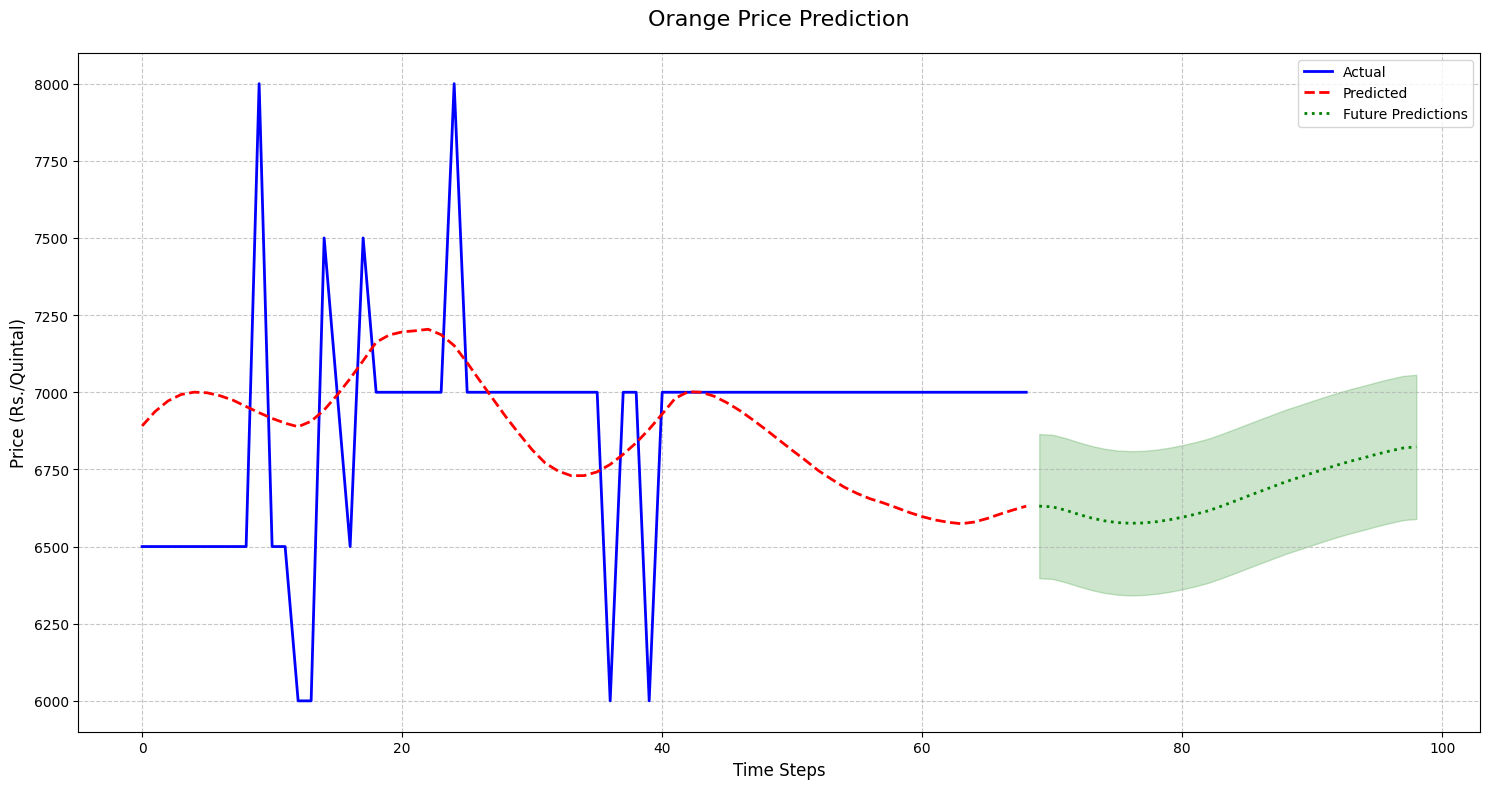


Processing banagreen...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.3789 - val_loss: 0.0146
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0639 - val_loss: 0.0166
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0555 - val_loss: 0.0095
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0511 - val_loss: 0.0075
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0535 - val_loss: 0.0069
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0493 - val_loss: 0.0068
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0489 - val_loss: 0.0107
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0421 - val_loss: 0.0074
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0410 - val_loss: 0.0090
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0297 - val_loss: 0.0116
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0296 - val_loss: 0.0071
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0318 - val_l

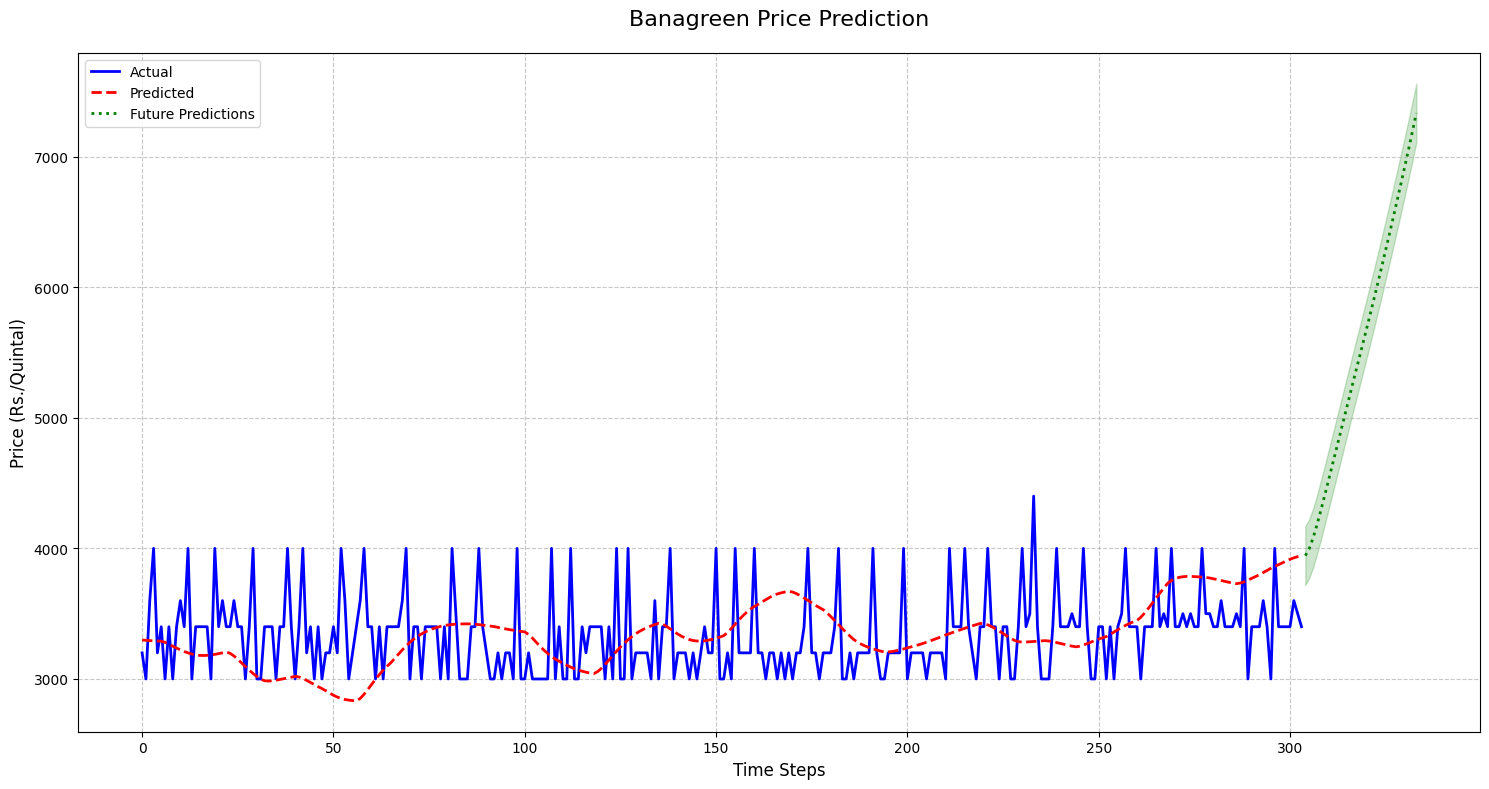


Processing beans...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0915 - val_loss: 0.0068
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0330 - val_loss: 0.0110
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0286 - val_loss: 0.0112
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0293 - val_loss: 0.0078
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0263 - val_loss: 0.0100
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0245 - val_loss: 0.0071
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0220 - val_loss: 0.0133
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0212 - val_loss: 0.0242
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0188 - val_loss: 0.0316
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0183 - val_loss: 0.0260
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0198 - val_loss: 0.0243
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step

Metrics for beans:
MSE: 2987141.1

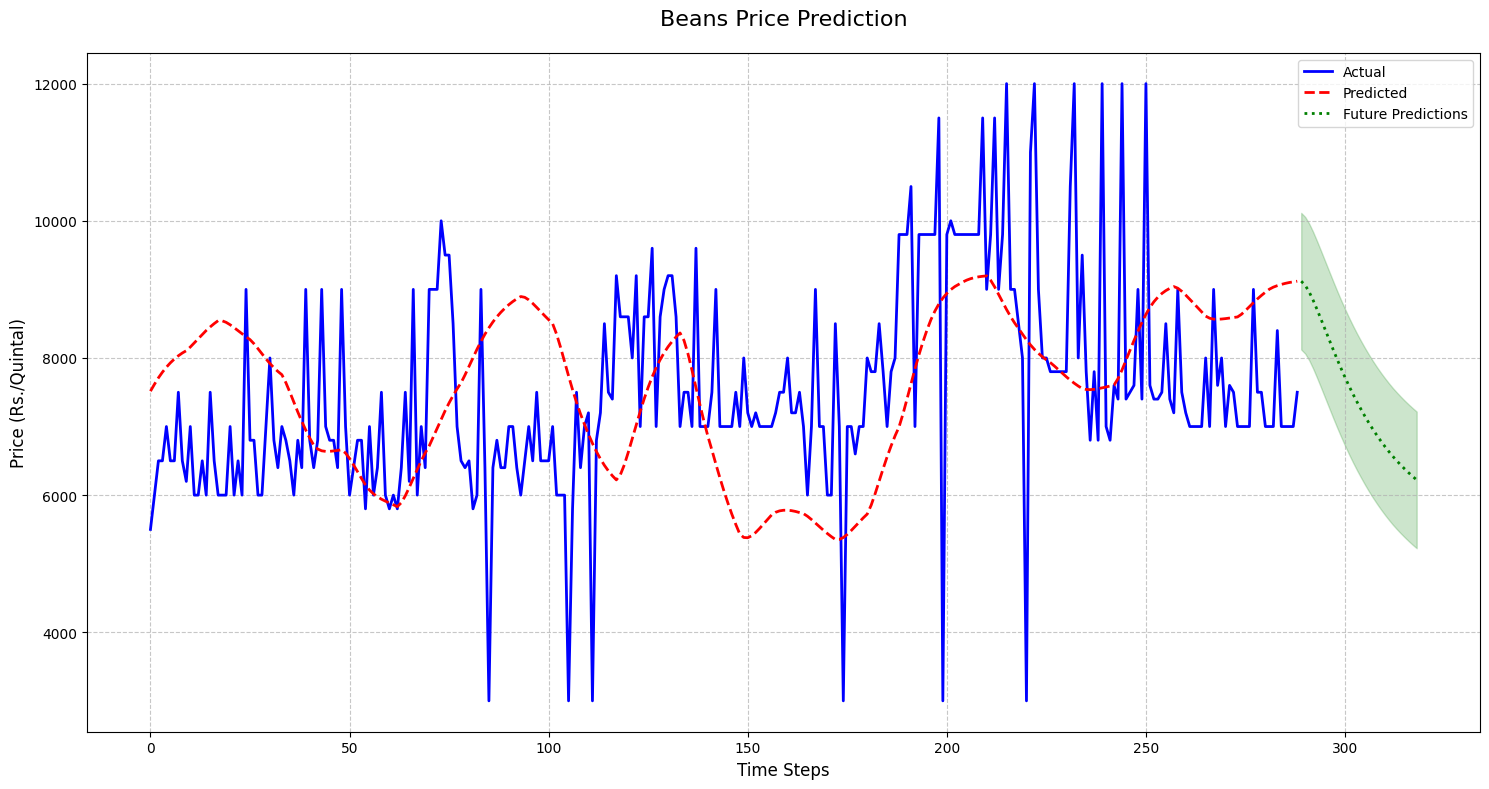


Processing beetroot...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.1782 - val_loss: 0.0530
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0384 - val_loss: 0.0485
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0380 - val_loss: 0.0307
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0291 - val_loss: 0.0372
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0263 - val_loss: 0.0347
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0285 - val_loss: 0.0310
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0295 - val_loss: 0.0299
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0288 - val_loss: 0.0317
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0305 - val_loss: 0.0248
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0262 - val_loss: 0.0291
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0266 - val_loss: 0.0279
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0258 - val_l

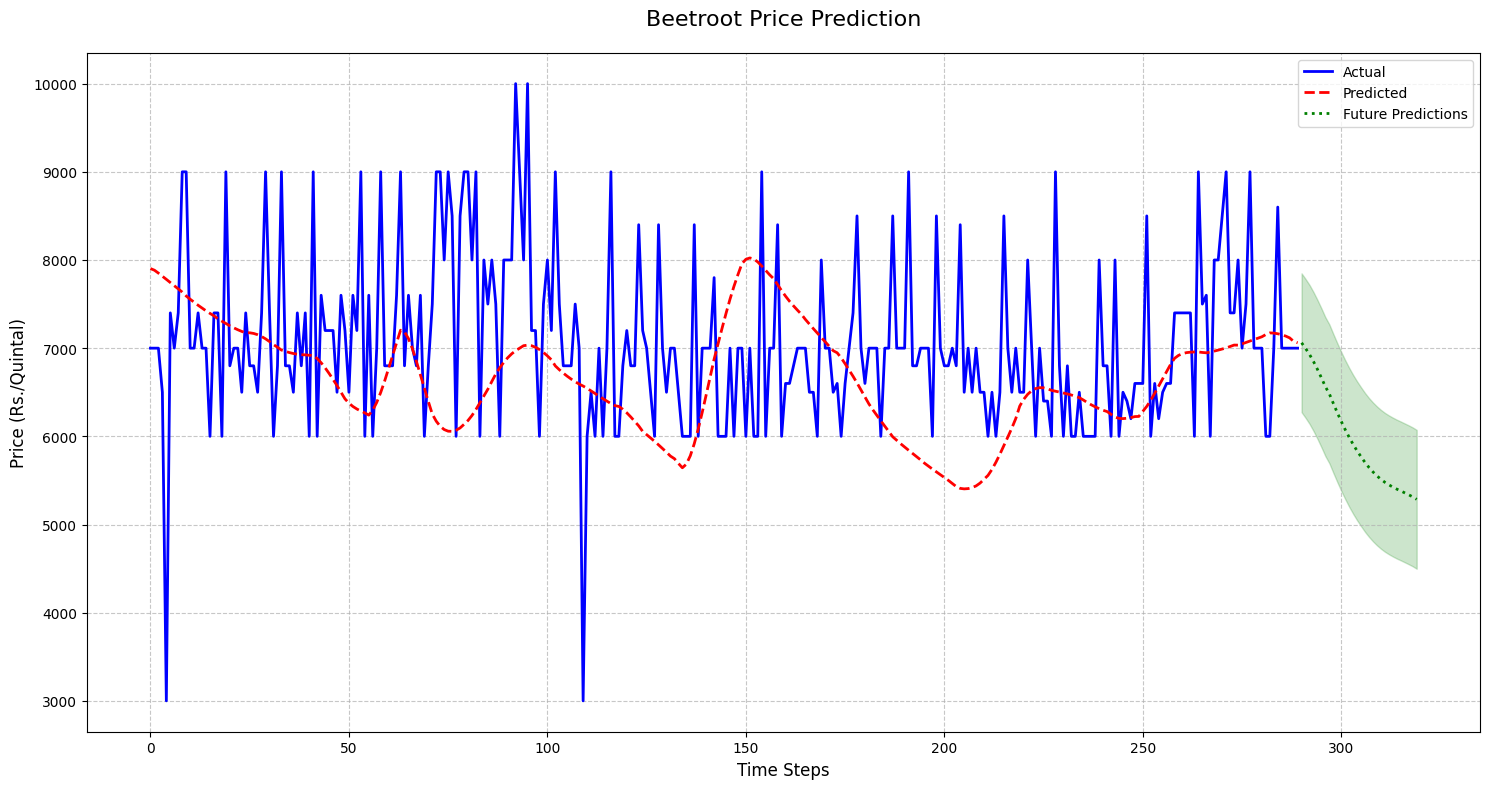


Processing bittergourd...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.1135 - val_loss: 0.0099
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0481 - val_loss: 0.0074
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0387 - val_loss: 0.0061
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0413 - val_loss: 0.0061
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0380 - val_loss: 0.0073
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0385 - val_loss: 0.0063
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0347 - val_loss: 0.0074
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0326 - val_loss: 0.0194
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0355 - val_loss: 0.0100
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0357 - val_loss: 0.0045
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0318 - val_loss: 0.0047
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0305 - val_l

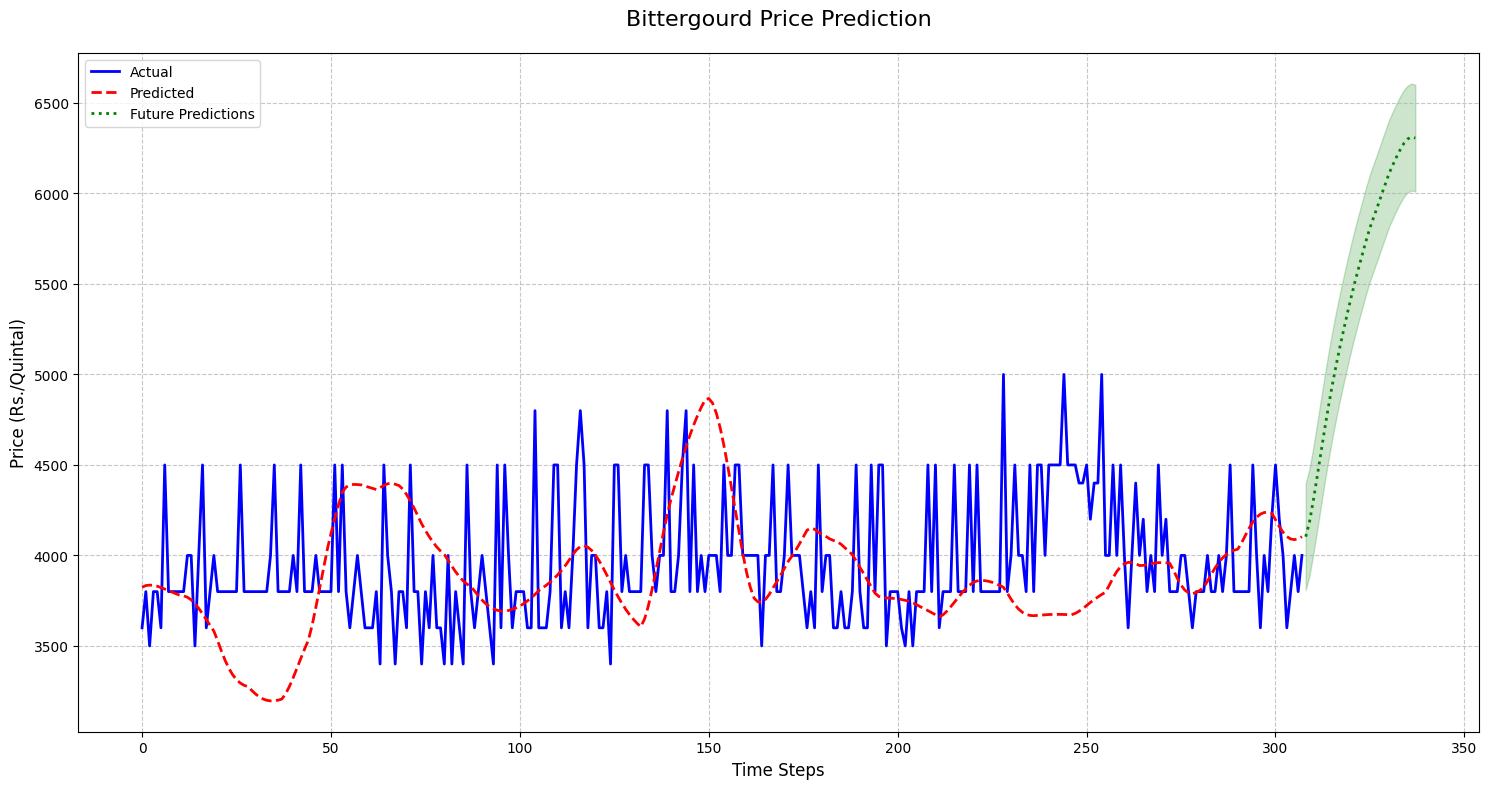


Processing cabbage...
Epoch 1/50


c:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0978 - val_loss: 0.0170
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0385 - val_loss: 0.0135
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0374 - val_loss: 0.0169
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0292 - val_loss: 0.0125
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0312 - val_loss: 0.0143
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0280 - val_loss: 0.0130
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0265 - val_loss: 0.0157
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0258 - val_loss: 0.0167
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0275 - val_loss: 0.0148
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0261 - val_loss: 0.0154
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0245 - val_loss: 0.0138
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0204 - val_l

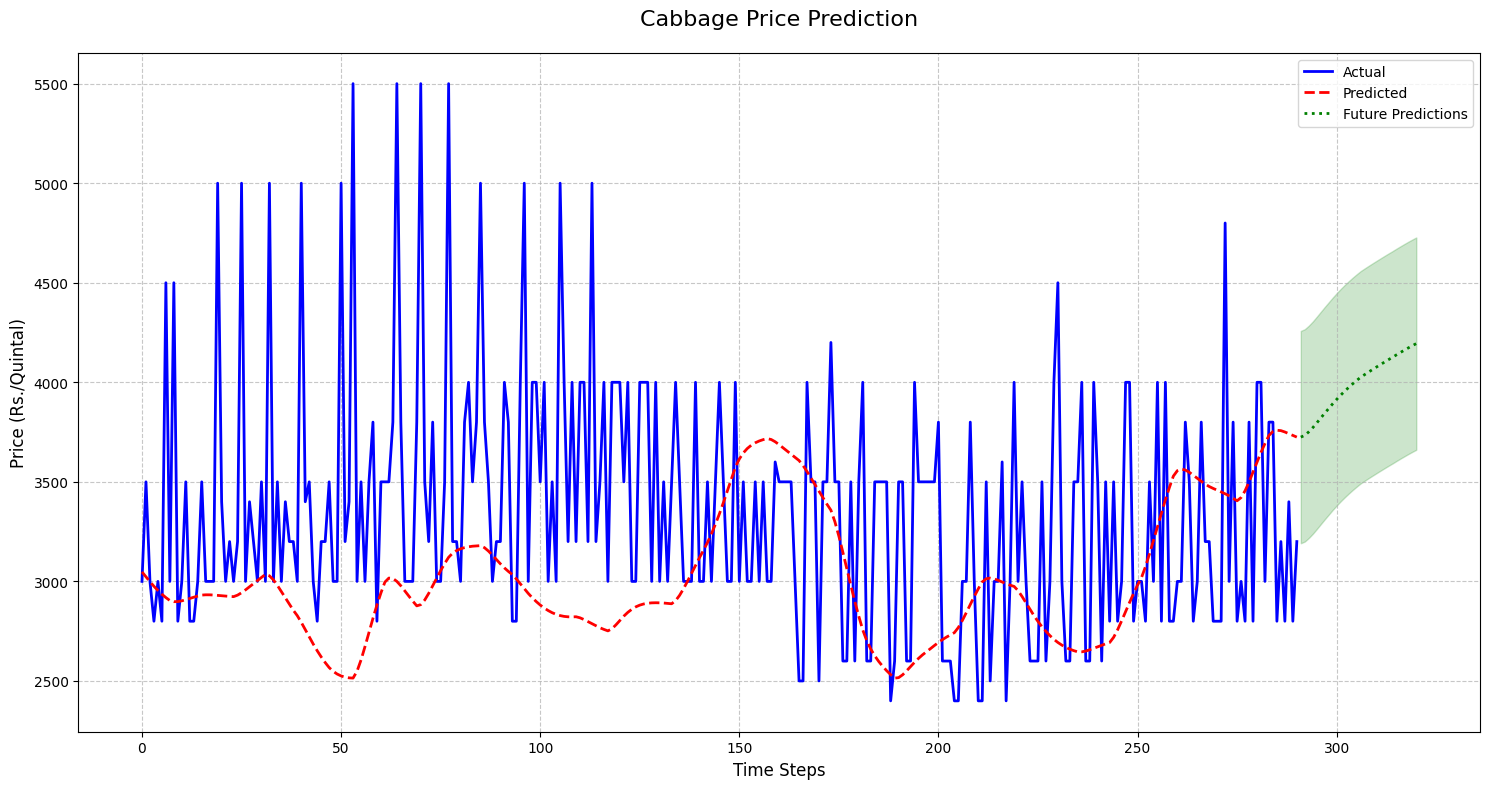

In [47]:
def main():
    # Load and preprocess data
    try:
        weather_data, crop_prices = load_and_preprocess_data()
        merged_data, features = merge_weather_price_data(weather_data, crop_prices)
    except Exception as e:
        print(f"Error in data loading: {e}")
        return None

    # Model parameters
    n_timesteps = 30
    test_size = 0.2

    results = {}
    for crop_name, data in merged_data.items():
        print(f"\nProcessing {crop_name}...")
        try:
            # Prepare sequences
            X, y, scaler_X, scaler_y = prepare_sequences(
                data, features, 'Modal Price (Rs./Quintal)', n_timesteps
            )

            # Split data
            split_idx = int(len(X) * (1 - test_size))
            X_train, X_test = X[:split_idx], X[split_idx:]
            y_train, y_test = y[:split_idx], y[split_idx:]

            # Train model
            input_shape = (X_train.shape[1], X_train.shape[2])
            model, history = train_model(X_train, y_train, X_test, y_test, input_shape, crop_name)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred = scaler_y.inverse_transform(y_pred)
            y_test = scaler_y.inverse_transform(y_test)

            # Generate future predictions
            future_pred = predict_future(model, X_test[-1:], 30, scaler_y)

            # Evaluate model
            metrics = evaluate_model(y_test, y_pred, crop_name)

            # Plot results
            plot_predictions(y_test, y_pred, future_pred, crop_name)

            # Store results
            results[crop_name] = {
                'model': model,
                'metrics': metrics,
                'predictions': {'test': y_pred, 'future': future_pred}
            }

        except Exception as e:
            print(f"Error processing {crop_name}: {e}")
            continue

    return results

if __name__ == "__main__":
    results = main()